In [1]:
from run_experiment import run_experiment
import optax
import mujoco

base_params = {
    "DATASET": {
        "PATH": "datasets/generated/test.csv",
        "DT": 0.001,
        "motor_id": 3,
        "num_lags": 5,
    },
    "SIM": {
        "PATH": "assets/single_motor/model/single_motor.xml",
        "INTEGRATOR": mujoco.mjtIntegrator.mjINT_EULER,
        "ITERATIONS": 1,
    },
    "TRAIN": {
        "EPOCH_NUM": 400,
        "BATCH_SIZE": 20000,
        "LEARNING_RATE": 1e-2,
        "TX": optax.adam(1e-2),
    },
}

for seed in list(range(0,10)):
    params = base_params.copy()
    params["SEED"] = seed
    params["EXPERIMENT_NAME"] = f"multi_run_seed_{seed}"
    print(f"Running experiment with seed {seed}")
    run_experiment(params)

Running experiment with seed 0
Running experiment with seed 1
Running experiment with seed 2
Running experiment with seed 3
Running experiment with seed 4
Running experiment with seed 5
Running experiment with seed 6
Running experiment with seed 7
Running experiment with seed 8
Running experiment with seed 9


In [8]:
import os
import joblib
import matplotlib.pyplot as plt
import numpy as np

def plot_convergence_stability_unified(root_folder="assets/experiments"):
    """
    Load all optimization results from the root folder and plot all parameter trajectories
    on a single plot. Uses Matplotlib's default color cycle: blue, orange, green.
    """
    experiment_dirs = [
        os.path.join(root_folder, d) for d in os.listdir(root_folder)
        if os.path.isdir(os.path.join(root_folder, d)) and
           os.path.exists(os.path.join(root_folder, d, "optimization_info.joblib"))
    ]

    if not experiment_dirs:
        print("No experiments found.")
        return

    print(f"Found {len(experiment_dirs)} experiments.")

    param_histories = {
        "armature": [],
        "frictionloss": [],
        "damping": [],
    }

    for exp_path in experiment_dirs:
        data = joblib.load(os.path.join(exp_path, "optimization_info.joblib"))
        hist = data["params"]

        param_histories["armature"].append([abs(p["armature"][0]) for p in hist])
        param_histories["frictionloss"].append([abs(p["frictionloss"][0]) for p in hist])
        param_histories["damping"].append([abs(p["damping"][0]) for p in hist])

    epochs = len(param_histories["armature"][0])
    x = np.arange(epochs)

    # Get default matplotlib color cycle
    default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    param_colors = {
        "armature": default_colors[0],       # blue
        "frictionloss": default_colors[1],   # orange
        "damping": default_colors[2],        # green
    }

    fig, ax = plt.subplots(figsize=(8, 4.5))

    for param_name in ["armature", "frictionloss", "damping"]:
        for i, run in enumerate(param_histories[param_name]):
            label = param_name if i == 0 else None  # only label first line
            ax.plot(
                x, run,
                color=param_colors[param_name],
                alpha=0.4,
                linewidth=1.5,
                label=label
            )

    ax.set_title("Parameters convergence")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Motor parameters value")
    ax.grid(True)
    ax.legend()
    fig.savefig(
    os.path.join("assets", "params_convergence.pdf"),
    format="pdf",
    bbox_inches="tight",
    )
    plt.tight_layout()
    plt.show()

Found 10 experiments.


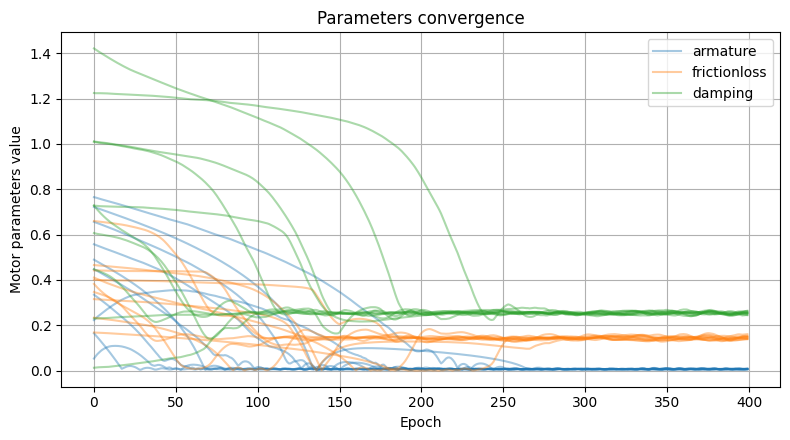

In [9]:
plot_convergence_stability_unified("assets/experiments")
